In [17]:
import pandas as pd
import os

# Folders containing tournament results and KenPom data
results_folder = "data/results"
kenpom_folder = "data/kenpom"

results_data = []
kenpom_data = []

# Load all tournament results and tag with the year
for file in os.listdir(results_folder):
    if file.endswith(".csv"):
        year = int(file.split("_")[0])
        df = pd.read_csv(os.path.join(results_folder, file))
        df["Year"] = year
        results_data.append(df)

# Load all KenPom files and tag with the year
for file in os.listdir(kenpom_folder):
    if file.endswith(".csv"):
        year = int(file.split("_")[0])
        df = pd.read_csv(os.path.join(kenpom_folder, file))
        df["Year"] = year
        kenpom_data.append(df)

# Combine all years into single DataFrames
all_results = pd.concat(results_data, ignore_index=True)
all_kenpom = pd.concat(kenpom_data, ignore_index=True)

print(f"Loaded {all_results.shape[0]} tournament games")
print(f"Loaded {all_kenpom.shape[0]} KenPom team entries")

Loaded 630 tournament games
Loaded 3561 KenPom team entries


In [18]:
kenpom_clean = all_kenpom[["TeamName", "AdjEM", "seed", "Year"]].copy()

In [19]:
# Standardize team names to ensure consistency between tournament results and KenPom data
team_name_fixes = {
    "Michigan State": "Michigan St.",
    "Ohio State": "Ohio St.",
    "Iowa State": "Iowa St.",
    "Kansas State": "Kansas St.",
    "Oregon State": "Oregon St.",
    "Utah State": "Utah St.",
    "Colorado State": "Colorado St.",
    "New Mexico State": "New Mexico St.",
    "North Dakota State": "North Dakota St.",
    "South Dakota State": "South Dakota St.",
    "East Tennessee State": "East Tennessee St.", 
    "Mississippi State": "Mississippi St.",
    "Arizona State": "Arizona St.",
    "Washington State": "Washington St.",
    "Weber State": "Weber St.",
    "Fresno State": "Fresno St.",
    "Kent State": "Kent St.",
    "Norfolk State": "Norfolk St.",
    "Morehead State": "Morehead St.",
    "Jacksonville State": "Jacksonville St.",
    "Alabama State": "Alabama St.",
    "Gardner-Webb": "Gardner Webb",
    "Long Beach State": "Long Beach St.",  
    "Col of Charleston": "Charleston",
    "Texas A&M-CC": "Texas A&M Corpus Chris",
    "North Kentucky": "Northern Kentucky",
    "Eastern Wash.": "Eastern Washington",
    "Southern California": "USC",
    "Miami (Fla.)": "Miami FL",
    "Miami (FL)": "Miami FL",
    "Saint Mary’s": "Saint Mary's",
    "St. Mary’s": "Saint Mary's",
    "St. Peter’s": "Saint Peter's",
    "UConn": "Connecticut",
    "Ole Miss": "Mississippi",
    "FAU": "Florida Atlantic",
    "FDU": "Fairleigh Dickinson",
    "Hawai'i": "Hawaii",
    "Cal State Bakersfield": "Cal St. Bakersfield",  
    "Cal State Fullerton": "Cal St. Fullerton",      
    "S. Dakota St.": "South Dakota St.",
    "Grambling State": "Grambling St.",             
    "McNeese": "McNeese St.",
    "SIU Edwards.": "SIU Edwardsville",             
    "Omaha": "Nebraska Omaha",
    "Wichita State": "Wichita St.",
    "Georgia State": "Georgia St.",
    "NC State": "N.C. State",
    "San Diego State": "San Diego St.",
    "Little Rock": "Arkansas Little Rock",
    "Florida State": "Florida St.",
    "Murray State": "Murray St.",
    "Pitt": "Pittsburgh",
    "Oklahoma State": "Oklahoma St.",
    "Wright State": "Wright St.",
    "Pennsylvania": "Penn",
    "UCSB": "UC Santa Barbara"
}

# Apply replacements
all_results["Team_1"] = all_results["Team_1"].replace(team_name_fixes)
all_results["Team_2"] = all_results["Team_2"].replace(team_name_fixes)

print("Team name standardization applied.")


Team name standardization applied.


In [20]:
# Handle special cases where team naming changed for specific years

# NC State in 2015 & 2018 should match KenPom as "North Carolina St."
mask_old_nc = (all_results["Year"].isin([2015, 2018]))
all_results.loc[mask_old_nc & (all_results["Team_1"] == "N.C. State"), "Team_1"] = "North Carolina St."
all_results.loc[mask_old_nc & (all_results["Team_2"] == "N.C. State"), "Team_2"] = "North Carolina St."

# McNeese in 2024 should match KenPom as "McNeese St."
mask_mc_2024 = (all_results["Year"] == 2024)
all_results.loc[mask_mc_2024 & (all_results["Team_1"] == "McNeese"), "Team_1"] = "McNeese St."
all_results.loc[mask_mc_2024 & (all_results["Team_2"] == "McNeese"), "Team_2"] = "McNeese St."

# SIUE and McNeese in 2025 need updated tournament naming
mask_siu_2025 = (all_results["Year"] == 2025)
all_results.loc[mask_siu_2025 & (all_results["Team_1"] == "SIU Edwardsville"), "Team_1"] = "SIUE"
all_results.loc[mask_siu_2025 & (all_results["Team_2"] == "SIU Edwardsville"), "Team_2"] = "SIUE"
all_results.loc[mask_siu_2025 & (all_results["Team_1"] == "McNeese St."), "Team_1"] = "McNeese"
all_results.loc[mask_siu_2025 & (all_results["Team_2"] == "McNeese St."), "Team_2"] = "McNeese"

print("Year-specific naming fixes applied.")

Year-specific naming fixes applied.


In [21]:
# Keep only seeded teams (tournament teams) from KenPom
kenpom_tourney = kenpom_clean.dropna(subset=["seed"])

# Merge KenPom data for Team_1
merged_df = all_results.merge(
    kenpom_tourney.rename(columns={"TeamName": "Team_1", "AdjEM": "AdjEM_1", "seed": "Seed_1"}),
    how="left",
    on=["Team_1", "Year"]
)

# Merge KenPom data for Team_2
merged_df = merged_df.merge(
    kenpom_tourney.rename(columns={"TeamName": "Team_2", "AdjEM": "AdjEM_2", "seed": "Seed_2"}),
    how="left",
    on=["Team_2", "Year"]
)

# Remove any leftover duplicate columns
merged_df = merged_df.rename(columns={
    "Seed_1_y": "Seed_1",
    "Seed_2_y": "Seed_2"
}).drop(columns=["Seed_1_x", "Seed_2_x"], errors="ignore")

# Quick verification
print("Columns after merge:", merged_df.columns.tolist())
print("Sample rows:")
print(merged_df.sample(5))

# Check if any games are still missing seeds after cleaning
missing_seeds = merged_df[merged_df["Seed_1"].isna() | merged_df["Seed_2"].isna()]
print("Games missing seeds:", missing_seeds.shape[0])

Columns after merge: ['Year', 'Round', 'Team_1', 'Team_2', 'Winner', 'AdjEM_1', 'Seed_1', 'AdjEM_2', 'Seed_2']
Sample rows:
     Year        Round        Team_1      Team_2        Winner  AdjEM_1  \
416  2022  Round of 32    Texas Tech  Notre Dame    Texas Tech  24.6410   
179  2017     Sweet 16      Kentucky        UCLA      Kentucky  27.2664   
205  2018  Round of 64          UMBC    Virginia          UMBC  -1.9086   
185  2017  Elite Eight        Oregon      Kansas        Oregon  23.8276   
463  2023  Round of 64  Michigan St.         USC  Michigan St.  16.7099   

     Seed_1  AdjEM_2  Seed_2  
416     3.0  13.6336    11.0  
179     2.0  22.9515     3.0  
205    16.0  32.1527     1.0  
185     3.0  25.9750     1.0  
463     7.0  15.6327    10.0  
Games missing seeds: 0


In [22]:
# Predict winners using two methods:
# KenPom: team with higher AdjEM
# Seed: team with lower (better) NCAA seed

merged_df["kenpom_pred"] = merged_df.apply(
    lambda row: row["Team_1"] if row["AdjEM_1"] > row["AdjEM_2"] else row["Team_2"],
    axis=1
)

merged_df["seed_pred"] = merged_df.apply(
    lambda row: row["Team_1"] if row["Seed_1"] < row["Seed_2"] else row["Team_2"],
    axis=1
)

# Flag games where KenPom and seeding disagreed
merged_df["methods_disagree"] = merged_df["kenpom_pred"] != merged_df["seed_pred"]

In [23]:
# Disagreement subset
disagreement_games = merged_df[merged_df["methods_disagree"]].copy()

# Add correctness flags
disagreement_games["kenpom_correct"] = disagreement_games["kenpom_pred"] == disagreement_games["Winner"]
disagreement_games["seed_correct"]   = disagreement_games["seed_pred"]   == disagreement_games["Winner"]

# Count totals
total_disagreements = len(disagreement_games)
kenpom_right = disagreement_games["kenpom_correct"].sum()
seed_right   = disagreement_games["seed_correct"].sum()

print("Total disagreement games:", total_disagreements)
print(f"KenPom correct: {kenpom_right}/{total_disagreements} ({kenpom_right/total_disagreements:.1%})")
print(f"Seed correct:   {seed_right}/{total_disagreements} ({seed_right/total_disagreements:.1%})")

Total disagreement games: 59
KenPom correct: 26/59 (44.1%)
Seed correct:   22/59 (37.3%)


In [24]:
# Build a summary table comparing KenPom vs Seeds
summary = pd.DataFrame({
    "Method": ["KenPom", "Seed"],
    "Correct Picks": [kenpom_right, seed_right],
    "Total Disagreements": [total_disagreements, total_disagreements],
    "Accuracy": [
        round(kenpom_right / total_disagreements, 3),
        round(seed_right / total_disagreements, 3)
    ]
})

print(summary)

   Method  Correct Picks  Total Disagreements  Accuracy
0  KenPom             26                   59     0.441
1    Seed             22                   59     0.373


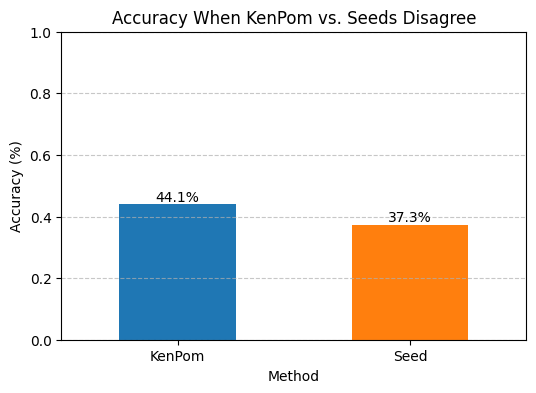

In [25]:
import matplotlib.pyplot as plt

# Bar chart: Accuracy when KenPom vs. Seeds disagree
ax = summary.plot(
    kind="bar",
    x="Method",
    y="Accuracy",
    legend=False,
    rot=0,
    color=["#1f77b4", "#ff7f0e"], 
    figsize=(6,4)
)

plt.title("Accuracy When KenPom vs. Seeds Disagree")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 1) 
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add text labels above bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1%}",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center", va="bottom", fontsize=10)

plt.show()

Disagreement games by confidence bin:
Confidence  Low (0–3)  Medium (3–6)  High (6+)
N                  48             7          4


C:\Users\craj5\AppData\Local\Temp\ipykernel_14844\704874349.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Confidence")


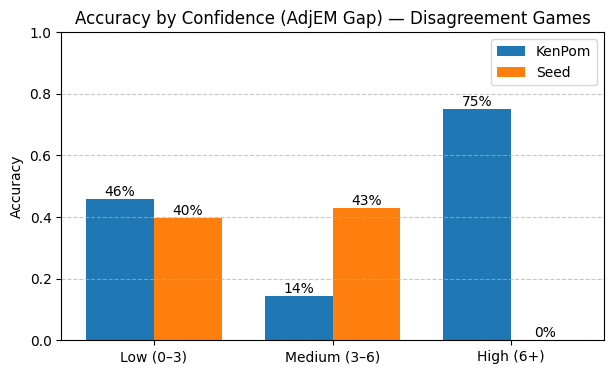

<Figure size 640x480 with 0 Axes>

In [26]:
# Confidence analysis: AdjEM gap vs. accuracy

# 1) Compute AdjEM gap as a confidence proxy (absolute difference)
disagreement_games = disagreement_games.copy()
disagreement_games["adjEM_diff"] = (disagreement_games["AdjEM_1"] - disagreement_games["AdjEM_2"]).abs()

# 2) Bin gaps
bins   = [0, 3, 6, float("inf")]
labels = ["Low (0–3)", "Medium (3–6)", "High (6+)"]
disagreement_games["Confidence"] = pd.cut(
    disagreement_games["adjEM_diff"], bins=bins, labels=labels, right=False
)

# 3) Group accuracy by bin
conf_df = (disagreement_games
           .groupby("Confidence")
           .agg(KenPom=("kenpom_correct", "mean"),
                Seed=("seed_correct", "mean"),
                N=("kenpom_correct", "size"))
           .reindex(labels))

print("Disagreement games by confidence bin:")
print(conf_df[["N"]].T) 

# 4) Plot side-by-side bars (KenPom vs. Seed) per confidence bin
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(labels))
width = 0.38

fig, ax = plt.subplots(figsize=(7, 4))
bars_kp = ax.bar(x - width/2, conf_df["KenPom"].values, width, label="KenPom")
bars_sd = ax.bar(x + width/2, conf_df["Seed"].values,   width, label="Seed")

ax.set_title("Accuracy by Confidence (AdjEM Gap) — Disagreement Games")
ax.set_ylabel("Accuracy")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.legend()

# add % labels
for bars in (bars_kp, bars_sd):
    for p in bars:
        ax.annotate(f"{p.get_height():.0%}",
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha="center", va="bottom", fontsize=10)

plt.show()

import os
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/accuracy_by_confidence.png", bbox_inches="tight", dpi=200)

In [27]:
# Identify notable disagreement outcomes
kenpom_wins = disagreement_games[
    (disagreement_games["kenpom_correct"]) & (~disagreement_games["seed_correct"])
][["Year", "Round", "Team_1", "Team_2", "Winner", "kenpom_pred", "seed_pred"]]

seed_wins = disagreement_games[
    (~disagreement_games["kenpom_correct"]) & (disagreement_games["seed_correct"])
][["Year", "Round", "Team_1", "Team_2", "Winner", "kenpom_pred", "seed_pred"]]

print("KenPom correct, Seeds wrong (first 10):")
print(kenpom_wins.head(10))

print("\nSeeds correct, KenPom wrong (first 10):")
print(seed_wins.head(10))

KenPom correct, Seeds wrong (first 10):
     Year        Round         Team_1      Team_2         Winner  \
35   2015  Round of 32  West Virginia    Maryland  West Virginia   
47   2015  Round of 32           Utah  Georgetown           Utah   
77   2016  Round of 64            VCU  Oregon St.            VCU   
92   2016  Round of 64        Gonzaga  Seton Hall        Gonzaga   
93   2016  Round of 64       Syracuse      Dayton       Syracuse   
94   2016  Round of 64         Butler  Texas Tech         Butler   
108  2016  Round of 32        Gonzaga        Utah        Gonzaga   
120  2016  Elite Eight       Oklahoma      Oregon       Oklahoma   
124  2016   Final Four      Villanova    Oklahoma      Villanova   
139  2017  Round of 64         Xavier    Maryland         Xavier   

       kenpom_pred   seed_pred  
35   West Virginia    Maryland  
47            Utah  Georgetown  
77             VCU  Oregon St.  
92         Gonzaga  Seton Hall  
93        Syracuse      Dayton  
94          B

In [28]:
# Find all games with missing seeds
missing = merged_df[merged_df["Seed_1"].isna() | merged_df["Seed_2"].isna()].copy()
print(f"Missing seeds rows: {len(missing)}\n")

# Unique team names causing the misses
offenders = pd.unique(pd.concat([
    missing.loc[missing["Seed_1"].isna(), "Team_1"],
    missing.loc[missing["Seed_2"].isna(), "Team_2"]
], ignore_index=True))
print("Offenders:", sorted(set(offenders)))

# Show which year/round/side is missing
def which_side(row):
    sides = []
    if pd.isna(row.Seed_1): sides.append("Team_1")
    if pd.isna(row.Seed_2): sides.append("Team_2")
    return ",".join(sides)

tmp = missing.assign(side=missing.apply(which_side, axis=1))
print("\nDetailed rows with missing seeds:\n")
print(tmp[["Year","Round","Team_1","Team_2","side"]].sort_values(["Year","Round"]).to_string(index=False))


Missing seeds rows: 0

Offenders: []

Detailed rows with missing seeds:

Empty DataFrame
Columns: [Year, Round, Team_1, Team_2, side]
Index: []


In [29]:
total_games = merged_df.shape[0]
disagreement_rate = total_disagreements / total_games
print(f"{total_disagreements} disagreement games out of {total_games} total "
      f"({disagreement_rate:.1%})")

59 disagreement games out of 630 total (9.4%)


In [30]:
# Final summary
kp_acc   = float(summary.loc[summary["Method"]=="KenPom", "Accuracy"])
seed_acc = float(summary.loc[summary["Method"]=="Seed",   "Accuracy"])

print("SUMMARY (2015–2025)")
print(f"- Disagreements: {total_disagreements} out of {total_games} total games "
      f"({disagreement_rate:.1%})")
print(f"- Accuracy in disagreement games: KenPom {kp_acc:.1%} vs. Seeds {seed_acc:.1%}")
print("Takeaway: KenPom offers a modest edge over seed-based picks when the two disagree.")

SUMMARY (2015–2025)
- Disagreements: 59 out of 630 total games (9.4%)
- Accuracy in disagreement games: KenPom 44.1% vs. Seeds 37.3%
Takeaway: KenPom offers a modest edge over seed-based picks when the two disagree.


C:\Users\craj5\AppData\Local\Temp\ipykernel_14844\2155714551.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  kp_acc   = float(summary.loc[summary["Method"]=="KenPom", "Accuracy"])
C:\Users\craj5\AppData\Local\Temp\ipykernel_14844\2155714551.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  seed_acc = float(summary.loc[summary["Method"]=="Seed",   "Accuracy"])


In [31]:
# Safety confirmation
import numpy as np

# No missing seeds after merge
assert merged_df[["Seed_1","Seed_2"]].isna().sum().sum() == 0, "Missing seeds after merge."

# No missing AdjEM in games used for predictions
assert merged_df[["AdjEM_1","AdjEM_2"]].isna().sum().sum() == 0, "Missing AdjEM values."

# Predictions must be one of the two teams
assert set(merged_df["kenpom_pred"].dropna().unique()).issubset(
    set(merged_df["Team_1"]).union(set(merged_df["Team_2"]))
), "kenpom_pred has unexpected team names."
assert set(merged_df["seed_pred"].dropna().unique()).issubset(
    set(merged_df["Team_1"]).union(set(merged_df["Team_2"]))
), "seed_pred has unexpected team names."

# Disagreement games summary should match printed summary
recalc_total_disagreements = int((merged_df["methods_disagree"]).sum())
assert recalc_total_disagreements == total_disagreements, (
    f"Disagreement count mismatch: {recalc_total_disagreements} != {total_disagreements}"
)

# Recompute accuracies and compare to 'summary' using the same rounding as the table
re_kp = float(disagreement_games["kenpom_correct"].mean())
re_sd = float(disagreement_games["seed_correct"].mean())
kp_acc_tab   = float(summary.loc[summary["Method"]=="KenPom", "Accuracy"])
seed_acc_tab = float(summary.loc[summary["Method"]=="Seed",   "Accuracy"])
assert round(re_kp, 3) == round(kp_acc_tab, 3), f"KenPom accuracy mismatch: {re_kp:.6f} vs {kp_acc_tab:.6f}"
assert round(re_sd, 3) == round(seed_acc_tab, 3), f"Seed accuracy mismatch: {re_sd:.6f} vs {seed_acc_tab:.6f}"

print("Safety checks passed ✅")

Safety checks passed ✅


C:\Users\craj5\AppData\Local\Temp\ipykernel_14844\4191968525.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  kp_acc_tab   = float(summary.loc[summary["Method"]=="KenPom", "Accuracy"])
C:\Users\craj5\AppData\Local\Temp\ipykernel_14844\4191968525.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  seed_acc_tab = float(summary.loc[summary["Method"]=="Seed",   "Accuracy"])
